# Lab 3. Tensorflow models 1

This lab will teach how to use Tensorflow 2.x by making a simple neural network model. Regradless of model's complexity, creating any model can be completed in a similar way. We will use the **Fashion MNIST** dataset, one of the variants of the MNIST dataset. It has the same property as a normal MNIST, with the same size (28*28) and the same number of classes (10), but the images represent fashion items rather than handwritten digits, which means it might have more complexity than normal MNIST. 

Because of its complexity in each class, the problem is significantly more challenging than normal MNIST. For example, a simple linear model reaches about 92% accuracy on MNIST, but only about 83% on Fashion MNIST. Below is an example of Fashion MNIST.


![alt text](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)


In today's lab, we will first try to create a simple fully connected network model and check its basic performance on Fashion MNIST. Then, as a self task, you will have a task to improve the performance by introducing convolutional layers on the same dataset. 

Based on your local machine's performance, the task might take a long time, so it is recommended to use the [Google Colab](https://colab.research.google.com/) since it can handle the lab contents with no processing bottleneck.

### Contents

- Import tensorflow and load a sample dataset
- Sequential fully connected network
- Different model creation strategies
- Other useful functions (Saving/Loading, Callbacks)

### Section 1: Import tensorflow and load a sample dataset


You might be able to install Tensorflow by using pip. You do not need to specify a GPU version. Our two course books and this lab assume that you at least have the version above 2.4. Currently Google Colab supports Tensorflow 2.9.2.

In [1]:
import tensorflow as tf

2023-02-02 15:20:00.054504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 15:20:02.728483: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/lucasvil/miniconda3/envs/tf/lib/
2023-02-02 15:20:02.728651: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/lucasvil/miniconda3/envs/tf/lib/
2023-02-02 15:20:02.728664: W tensorflow/compiler/tf2te

In [2]:
from tensorflow import keras

In [3]:
import numpy as np

In [4]:
# version?
tf.__version__

'2.11.0'

In [5]:
# keras version?
keras.__version__

'2.11.0'

We will use the [Fashion MNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist) data available in keras, which has 70,000 article images. Each example is a 28x28 grayscale image, associated with a label from 10 classes. 

In [6]:
# fashion_mnist
fashion_mnist = keras.datasets.fashion_mnist

#### Dataset handling 1: Traditional way with scikit-learn

Keras datasets already have separate sets for training and testing. You can simply divide those sets as follows at the same time you load the dataset:

In [7]:
# load_data
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


This dataset is loaded as a NumPy array which we learned before in Lab 1. You can use all the methods you learned to check the properties of the dataset, like **shape** or **describe**.

In [8]:
# type?
type(X_train_full)

numpy.ndarray

In [9]:
# shape?
X_train_full.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [10]:
np.unique(y_train_full)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

As the dataset is composed of grayscale pixels, the datatype of it is unsigned integer. The dataset also has a pixed range [0, 255] so it does not need to take higher bit than 8.

In [11]:
# dtype?
X_train_full.dtype

dtype('uint8')

Besides that, Tensorflow models are also usually evaluated by one more separate set called validation set as training is an iterative and time-consuming process and we do not know when we need to stop clearly. So we would like to estimate the right time to interrupt the training process by checking its performance for each iteration. 

To create a validation set, there can be many options, we can explicitly split the dataset using index, or we can just use a training set but with the option stating we want to validate, when we actually fit the model. However, this time we will use scikit-learn's train_test_split method to create a validation set as it can provide a nice stratification option.

In [ ]:
# Introduced in the coursebook 

#X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
#y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

We need a simiple normalization - as we all know the graysclae ranges from 0 to 255...

In [12]:
# X_train_full, X_test
X_train_full = X_train_full / 255.
X_test = X_test / 255.

In [13]:
from sklearn.model_selection import train_test_split
# Create X_train, X_valid, y_train, y_valid using train_test_split
#  - Use X_train_full and y_train_full
#  - Enable shuffle and stratification
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, shuffle=True, stratify=y_train_full)

In [14]:
# shape?
X_train.shape, X_valid.shape

((45000, 28, 28), (15000, 28, 28))

Here we prepared the class names of the fashion MNIST dataset for your convenience.

In [15]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [16]:
# Use the numeric label to get the class name
label_no = 31
y_train[label_no]

1

We can also try to see each data instance by using **plt.imshow**.

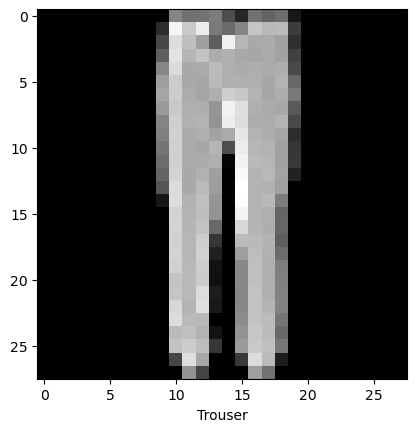

In [19]:
import matplotlib.pyplot as plt
plt.imshow(X_train[label_no], cmap='gray') # cmap to make it recognize grayscale
plt.xlabel(class_names[y_train[label_no]])
plt.show()

Our objective is to create a model with the high accuracy on this dataset. Let's start to create our first model!

#### Dataset handling 2: Tensorflow way with tf.Data

To load and process the dataset, you can of course use scikit-learn, but Tensorflow itself also has a module called tf.Data to load and process the dataset recognizable by the model. This is powerful when you deal with larger dataset so you cannot keep it in memory.

In [20]:
# fashion_mnist
fashion_mnist = keras.datasets.fashion_mnist

In [21]:
train_data, test_data = fashion_mnist.load_data()

From_tensor_slice will recognize the elements in the first axis.

In [22]:
# Use tf.data.Dataset.from_tensor_slice to create the train and test datasets
train_data = tf.data.Dataset.from_tensor_slices(train_data)
test_data = tf.data.Dataset.from_tensor_slices(test_data)

2023-02-02 15:53:12.718223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-02 15:53:12.825954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-02 15:53:12.826080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-02 15:53:12.834114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebui

In [23]:
train_data

<TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

For normalization, you can use the map function or tensorflow also has a normalization layer that you can use in the layers directly [layers.Normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization).

In [24]:
# cardinality will return the number of instances
train_data.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=60000>

In [25]:
# Tensorflow supports the map function
# - Use the map function from train_data and test_data to normalize the data. You should specify the data type when you apply the function using tf.cast.
# - The map function can receive each instance as a form of x and y and return the values as a tuple
train_data = train_data.map(lambda x, y: (tf.cast(x, tf.float32) / 255., y))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [26]:
test_data = test_data.map(lambda x, y: (tf.cast(x, tf.float32) / 255., y))


In [27]:
train_data.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=60000>

In [28]:
# You can specify the validation set when you actually fit the model.
# - there is also validation_split option when you fit the model but it does not support tf.Data yet!
# - Use 'take' and 'skip' methods to create training and validation sets.
# train_tf = train_data.take(45000)
# valid_tf = train_data.skip(45000)

# NEW in Tensorflow 2.11.0
train_tf, valid_tf = keras.utils.split_dataset(train_data, left_size=0.75, shuffle=True)

2023-02-02 16:00:59.782398: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 47040000 exceeds 10% of free system memory.
2023-02-02 16:01:34.879512: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 141120000 exceeds 10% of free system memory.
2023-02-02 16:01:35.256074: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 141120000 exceeds 10% of free system memory.
2023-02-02 16:01:35.458317: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 47040000 exceeds 10% of free system memory.


In [29]:
valid_tf.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=15000>

In [30]:
tf.data.experimental.cardinality(train_tf)

<tf.Tensor: shape=(), dtype=int64, numpy=45000>

We can access an instance by using the take method.

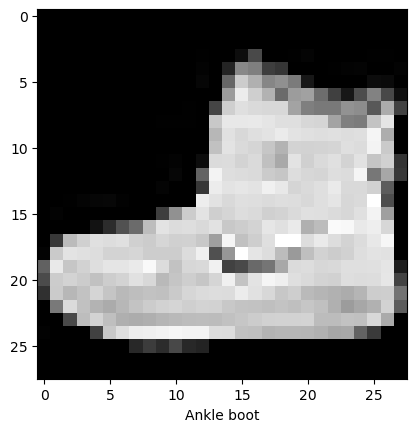

In [31]:
for element in train_data.take(1):
  plt.imshow(element[0], cmap='gray') # cmap to make it recognize grayscale
  plt.xlabel(class_names[element[1]])
  plt.show()

**Shuffling, Repeating, and making batches**: Using tf.Data, you can easily shuffle, repeat, and batch the dataset. To apply those three methods, you need to be careful about their order (especially with batch). Repeat method does not copy the data in memory n times. It just specifies how many times it can iterate.

 - [Repeating and epoch](https://stackoverflow.com/questions/66557699/difference-between-tf-data-datasets-repeatepochs-vs-model-fit-epochs-epochs)

In [32]:
REPEAT_SIZE = 2
BUFFER_SIZE = 10000
BATCH_SIZE = 32 # according to research not big difference when increasing to e.g. 64, 128

In [42]:
# Buffer size should be big enough to really shuffle the data
# - try to repeat the data, shuffle the data, and finally make batches!
# - these operations can be chained
train_tf_processed = train_tf.repeat(REPEAT_SIZE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [43]:
# validation set does not need to be repeated and shuffled since it all will be used at once - but MUST be batched.
valid_tf_processed = valid_tf.batch(BATCH_SIZE)

Some useful parameters for those three functions:
 - reshuffle_each_iteration
 - drop_remainder

Batch operation makes any operations further handle the data batch-based. For example, if you have 10 batches and 100 data instances and call the shuffle function, it will shuffle 10 batches and the contents within each batch will remain the same.

### Section 2: Sequential fully connected network

The easiest way to create a Tensorflow model is to use Sequential(). To create a model you can just sequentially add the layer with specifying activation functions and the number of nodes. It also fully supports Tensorflow's built-in functions to check the model parameters and various callbacks. You might use this form of the models most frequently.

When you create a model, you should specify few things as follows: **activation function**, **input shape**, and **node size**.

In [44]:
# Keras Sequential API supports two different ways of creating a model. Both ways are entirely equivalent.

# 1. Create the model first and add the layers
# - Define the model by calling keras.models.Sequential()
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28], name='flatten'))
model.add(keras.layers.Dense(300, activation='relu', name='dense1'))
model.add(keras.layers.Dense(100, activation='relu', name='dense2'))
model.add(keras.layers.Dense(10, activation='softmax', name='output'))

# - Add layers by calling model.add(), with the layer from keras.layers and name (optional)
# - Input, Flatten, Dense

# Our expected structure
# =======================
# Input (28, 28)
# Flatten
# Dense(300, activation = relu)
# Dense(100, activation = relu)
# Dense(10, activation = softmax)

# model.add(keras.layers.Input([28, 28], name='input'))
# model.add(keras.layers.Flatten(name='flatten')) # 28*28
# model.add(keras.layers.Dense(300, activation='relu', name='dense1'))
# model.add(keras.layers.Dense(100, activation='relu', name='dense2'))
# model.add(keras.layers.Dense(10, activation='softmax', name='output'))

# - input_shape for the first layer - or keras.layers.InputLayer explicitly
# - keras.layers.InputLayer is completely optional

In [ ]:
# 2. Equivalent way - Create the model with the full information of the layers at once - Put things in the list.
model = keras.models.Sequential([
    # You can skip the input layer and instead put input_shape parameter in your first layer!
    keras.layers.Flatten(input_shape=[28, 28], name='flatten'),
    keras.layers.Dense(300, activation='relu', name='dense1'),
    keras.layers.Dense(100, activation='relu', name='dense2'),
    keras.layers.Dense(10, activation='softmax', name='output')
])

We can visualize the model using **keras.utils.plot_model**. It helps to figue out (or validate) the structure of complete models having multiple paths.

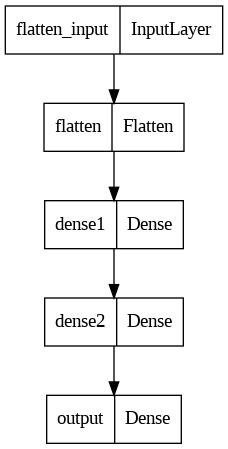

In [45]:
# keras.utils.plot_model
# Sequential model means there is only one path!
keras.utils.plot_model(model)

model.summary() function can calculate the number of parameters the model has **only if** we provide an input information.

In [46]:
# summary
# parameter number only works with input shape
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense1 (Dense)              (None, 300)               235500    
                                                                 
 dense2 (Dense)              (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Summarization of model parameters is only possible when the model has an input information as it needs to calculate the fully connected parameters from the input layer.

In [ ]:
model3 = keras.models.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(300, activation="relu"),
  keras.layers.Dense(100, activation="relu"),
  keras.layers.Dense(10, activation="softmax") 
])

# You should fit the model first to make this summary function work as the model has no info of calculating parameters
model3.summary() # parameter number only works with input shape --> It will throw error

A model instance has various attributes to get layers, weights - which are just for your reference to check the real values.

In [47]:
# You can get layer objects from 'layers'
model.layers

In [ ]:
model.layers[1] # one hidden layer

In [ ]:
model.layers[1].name # name of this hidden layer

In [48]:
# If you specified the name of the layer, you can get it more easily
model.get_layer('dense1')

In [49]:
dense1 = model.get_layer('dense1')

In [50]:
# get_weights
weights, bias = dense1.get_weights()

In [51]:
# weights
weights

array([[-0.01591868, -0.06024564, -0.06681566, ...,  0.0252685 ,
         0.00748981, -0.04223081],
       [-0.04825017,  0.05238718, -0.05651011, ..., -0.07263192,
        -0.03776424,  0.0548204 ],
       [-0.00261407,  0.03240919, -0.04419219, ..., -0.04255849,
        -0.06250103, -0.01583939],
       ...,
       [-0.05936695,  0.06477976, -0.03463263, ..., -0.04907855,
         0.00495475, -0.06919733],
       [-0.03499363,  0.01678627,  0.05695595, ..., -0.07105491,
         0.00839298, -0.03914707],
       [-0.02805859, -0.06562814,  0.06270005, ...,  0.01437215,
         0.03978418, -0.01154378]], dtype=float32)

In [52]:
# bias
bias

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Since we have not compiled and trained our model, we can just check the initialized weight and bias by the [Glorot uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform) initialization. We can change the normalization strategy by changing **kernel_initializer** parameter of each layer.

The next thing we should do after we create a model is to **compile** it, which means we specify which loss function and optimizer we would like to use, and which metrics we would like to print for evaluation.

In [53]:
# 3. Compile the model with the loss function, optimizer, metrics with the complie method
# - loss = categorical_crossentropy (sparse!)
# - optimizer = sgd
# - metrics = accuracy
#sigmoid activation and binary_crossentropy loss
############################################
"sgd"
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.01), metrics=['accuracy'])



############################################

# Another way of defining each parameter

# keras.losses.sparseCategoricalCrossEntropy
# keras.optimizers.SGD(lr=????)
# keras.metrics.accuracy

In [54]:
y_train

array([5, 8, 2, ..., 0, 3, 0], dtype=uint8)

In [55]:
# To_categorical
# If we do not want to use sparse_categorical -> one hot encoding
# If we want to turn it back -> np.argmax
keras.utils.to_categorical(y_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Now it is time to train our first model. You can train this Tensorflow model in the same way as you do with scikit-learn-based models.

**If you use scikit-learn based split datasets**: You need to put both training and validation data when you fit the model.

In [57]:
# 4. Fit the model on the data with model.fit
# - if you use scikit-learn-based datasets, the method receives X, y, epochs, validation_data=[X, y]
# - validation_data or validation_split = 0.1
history = model.fit(X_train, y_train, validation_data=[X_valid, y_valid], epochs = 10)

# Some parameters...
# - class_weight - dictionary to specify the weight -> loss will be calculated with the weighted sum
# - sample_weight - instance-level weight specification

# Maybe we can continue training as validation accutacy is going down!

Epoch 1/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7534 - accuracy: 0.7535 - val_loss: 0.6021 - val_accuracy: 0.7871
Epoch 2/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.5086 - accuracy: 0.8230 - val_loss: 0.5030 - val_accuracy: 0.8266
Epoch 3/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.4623 - accuracy: 0.8380 - val_loss: 0.4639 - val_accuracy: 0.8353
Epoch 4/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.4349 - accuracy: 0.8486 - val_loss: 0.4459 - val_accuracy: 0.8480
Epoch 5/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.4130 - accuracy: 0.8546 - val_loss: 0.4069 - val_accuracy: 0.8589
Epoch 6/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.3978 - accuracy: 0.8604 - val_loss: 0.4291 - val_accuracy: 0.8520
Epoch 7/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.3836 - accuracy: 0.8652 - val_loss: 0.4101 - val_accuracy:

**If you use tf.Data based datasets**: You only put training data which will also contain validation part and specify the proportion as a parameter.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28], name='flatten'),
    keras.layers.Dense(300, activation='relu', name='dense1'),
    keras.layers.Dense(100, activation='relu', name='dense2'),
    keras.layers.Dense(10, activation='softmax', name='output')
])

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="sgd", 
              metrics=["accuracy"])

history = model.fit(train_tf_processed, validation_data=valid_tf_processed, epochs=30)

**Progress check**: Fit function returns the history object which has some informaton about the training process.

In [58]:
# history.params: EPOCHS, STEPS, VERBOSE
history.params

{'verbose': 1, 'epochs': 10, 'steps': 1407}

In [59]:
# history.epoch
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

history.history (dictionary) will have some information such as loss, accuracy on the training and validation sets over time.

In [60]:
# history.history - keys
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

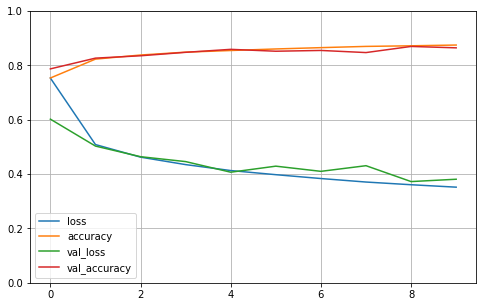

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

**Evaluation**: model.evaluate will return the metric scores!

In [62]:
model.evaluate(X_test, y_test) #evaluate on the test set

313/313 [==============================] - 1s 2ms/step - loss: 0.4145 - accuracy: 0.8504


[0.41448360681533813, 0.8503999710083008]

Prediction on new instances.

In [64]:
X_new = X_test[:3]
y_proba = model.predict(X_new) # this returns a probability?
y_proba.round(2)

1/1 [==============================] - 0s 15ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.11, 0.  , 0.75],
       [0.  , 0.  , 0.88, 0.  , 0.02, 0.  , 0.1 , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [65]:
import numpy as np
np.array(class_names)[np.argmax(y_proba, axis=1)] #if we want to know the class names

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

### Section 3: Different ways of making a model

Sequential API is the easiest way of creating any model if it has one continuous path. However, we may want to create more complex models that more look like a tree with many branches, which cannot be done only with the Sequential API. Then we need another method called **Functional API** and **Subclass API**.

#### Functional API

Non-sequential models (Wide & Deep network) - if we want to create links as we want.

- Here we can get two separate inputs and merge them together by using `keras.layers.concatenate`.

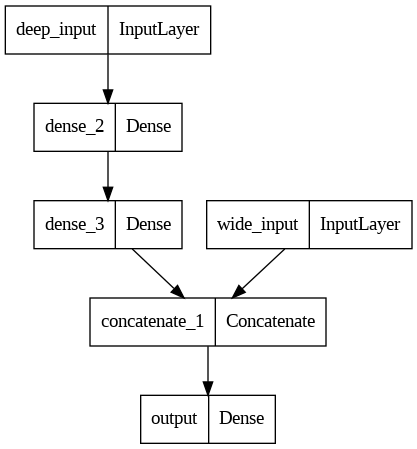

In [ ]:
# CASE 1 - we can have two different input sources!

input_A = keras.layers.Input(shape=[5], name="wide_input") #name is good for managing the model
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)


# compile works in the same way
model1.compile(loss=keras.losses.mse, optimizer=keras.optimizers.SGD(learning_rate=1e-3))

keras.utils.plot_model(model1)

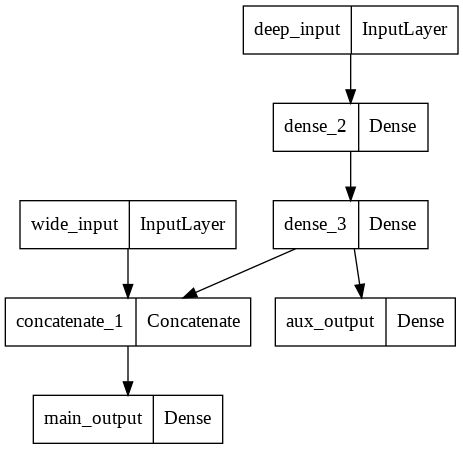

In [ ]:
# CASE 2 - we can have more than one input and output
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model2 = keras.Model(inputs=[input_A, input_B], outputs=[output,
aux_output])
model2.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1],
optimizer="sgd")
keras.utils.plot_model(model2)

In [ ]:
#Sometimes this approach can be better for multiple tasks - multitask classification
# auxiliary output - output during the process - to ensure some part of output learns something
# even before the network ends

model2.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer="sgd")

#### Subclass API

Subclass API (or Subclassing API) will give us a full access to the library. We have a freedom to define our own structure and we can integrate different loops or Numpy functions in the middle of the network. However, since the structure is not declaritive (which means the library knows the full structure before running it), Keras cannot infer the structure very well as it is no longer declaritive - so we cannot simply use easy functions that are given by Keras such as saving the model.

In [ ]:
# Drawbacks
# - keras cannot save the model (especially it can only save weights)
# - keras cannot infer the stucture

class WideAndDeepModel(keras.Model):
  def __init__(self, units=30, activation="relu", **kwargs):
    # Definition of the models
    super().__init__(**kwargs) # handles standard args (e.g., name)
    self.hidden1 = keras.layers.Dense(units, activation=activation)
    self.hidden2 = keras.layers.Dense(units, activation=activation)
    self.main_output = keras.layers.Dense(1)
    self.aux_output = keras.layers.Dense(1)

  def call(self, inputs):
    # Its order
    input_A, input_B = inputs
    hidden1 = self.hidden1(input_B)
    
    hidden2 = self.hidden2(hidden1)
    concat = keras.layers.concatenate([input_A, hidden2])
    main_output = self.main_output(concat)
    aux_output = self.aux_output(hidden2)
    return main_output, aux_output
    
model_subclass = WideAndDeepModel()

### Section 4: Other useful and frequently used functions

Save and load the model.

In [66]:
# save - Tensorflow 2.x supports SavedModel type
model.save("model.h5")

In [ ]:
# keras.models.load_model
model = keras.models.load_model("model.h5")

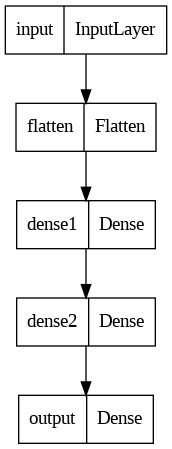

In [ ]:
# plot the model
keras.utils.plot_model(model)

**Callbacks**: We can have some useful functionalities while fitting the model such as: early stopping, checkpointing, learning rate scheduler.

In [ ]:
# Checkpointing - keras.callbacks.ModelCheckpoint
# - save_best_only
# - save_freq
checkpoint_cb = keras.callbacks.ModelCheckpoint("checkpoint")
# checkpoint_cb = keras.callbacks.ModelCheckpoint("checkpoint", save_best_only=True)


# Early stopping - keras.callbacks.EarlyStopping
# count the number of epochs with the loss higher than the current lowest
# - patience
# - restore_best_weights
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(train_tf_processed, validation_data=valid_tf_processed, epochs=30, callbacks=[checkpoint_cb, early_stopping_cb])

In [ ]:
#LearningRateScheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lrs_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

[Some more useful callbacks](https://blog.paperspace.com/tensorflow-callbacks/)

### Task 1. Regression MLP using the Sequential model

We have created a classification model on Fashion MNIST with Tensorflow. In addition, we can of course use similar Tensorflow models to solve regression tasks. **How can we do that?** Which part should we change to make it work on regression tasks? That would be our first task in this lab. Based on your knowledge from the second lecture, you may be able to figure out which part you need to change.

Create a regression model using the sequential model we used above and train it on the california housing dataset. Report its test error and compare it to the error from the simple linear regression model from scikit-learn.

We will give you a diagram of an expected model. You may need to change **a loss function** and input / output layers as we no longer deal with images and classification. Feel free to use scikit-learn but we still recommend you to practice preprocessing with Numpy for your skills.

In [ ]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)

1. You can load the dataset with the **fetch_california_housing** function.

2. Divide the dataset into three parts - training, validation, and test. 

3. Apply **standardization**. Please be careful that you should only use training set's properties.

4. Define the following model. Create 30 different nodes in the hidden layer.

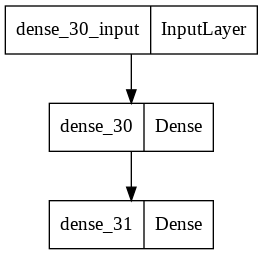

5. Complie the model with a proper loss function for the regression task and fit the model with at least 20 epochs.

6. Evaluate your model on the test set.

7. (Optional) You might want to compare the result from your neural network model with the scikit-learn models we used before!

There are many options to fine-tune the parameters used for your model and the easiest option is to use scikit-learn.

In [ ]:
# Load the TensorBoard notebook extension
# %load_ext

# os for complicated and sophisticated path handling
import os
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


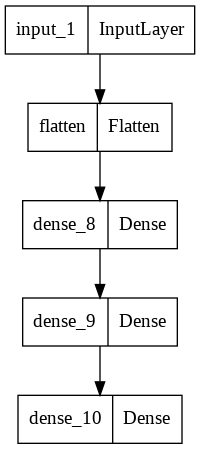

In [ ]:
keras.utils.plot_model(model)

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 

#################
# Save current history information into a designated directorya
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#################

model.fit(x=X_train, 
          y=y_train, 
          epochs=10, 
          validation_data=(X_valid, y_valid), 
          callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir logs

### Task 2: More layers & Convolutional Neural Network

So far, we have checked various functions of Tensorflow 2.0 by creating a fully connected network. However, making a convolutional neural network model can be also done in the exactly same way. All we need to do is just to bring different types of the layers besides **keras.layers.Dense**.

Here is our second task, you need to bring a convolutional neural network model that works better on our **Fashion MNIST** dataset.

Before doing that, let's try to make a larger fully connected network to see how much more improved performance we can get.

1. Create the following model with 30 epochs and return the test aaccuracy. For each Dense layer, set the following number of nodes: [1024 (First), 128 (Second), 10 (Output)]. 
 - Enable EarlyStopping callback with patience = 5, restore_best_weights=True.
 - This task can take some time, if you use Colab, you can enable a GPU option to make the training process faster.

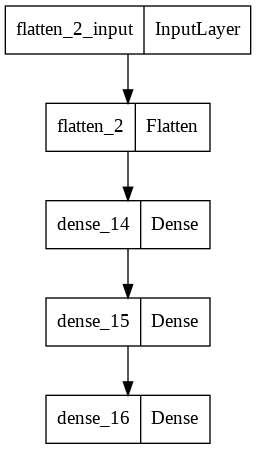

Unfortunately, we could not manage to get an accuracy above 90%. Since we have a image dataset, we can expect that a CNN model might bring better results. Your next task is to develop a CNN model using the same Sequential API. Here you can rather try to make your own model or try to make the following model.

- Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1))
- MaxPooling2D(2, 2)
- Conv2D(64, (3,3), activation='relu')
- MaxPooling2D(2, 2)
- Flatten
- Dense(128, activation='relu')
- Dense(10, activation='softmax')


In this case, you need to reshape the dataset in a different way as the CNN network will receive 2D images, not flattened vectors anymore. Use `Adam` optimizer and **accuracy** as a metric. You can train your model using a full training set (without validation set) but with validation frequency = 0.2. Evaluate your loss and accuracy with the `evaluate` function.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2